# Topic Modeling w/ LDA and Gibbs Sampling

## Overview

In this notebook, we discuss a popular topic modeling algorithm, **Latent Dirichlet Allocation (LDA)**, and demonstrate how it works by applying it to a very simple but illustrative problem. We also discuss the **Gibbs sampling** algorithm for computing the posterior distribution of the model and explore some interesting issues related to it.

For an overview of LDA, read the [Wikipedia page](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). For a more detailed explanation, read the [original paper](http://jmlr.csail.mit.edu/papers/v3/blei03a.html) by Blei, Ng, and Jordan. Briefly, LDA is a generative model in which each document in a corpus is represented as a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model), with each word in document $d$ generated in a two-step process as follows:
1. A topic $t$ is drawn from the document's topic distribution $P(t\,|\,d)$.
2. A word $w$ is sampled from the word distribution $P(w\,|\,t)$ associated with the topic $t$ drawn in step 1.

Our task is to find the document-topic and topic-word distributions that generated an observed set of documents; that is, we need to find $P(t\,|\,d)$ for each document $d$ in the corpus and $P(w\,|\,t)$ for each topic $t$. The original LDA paper describes an [expectation-maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) for computing the posterior distribution, but in this notebook we use the collapsed Gibbs sampling algorithm described in a [later paper](https://www.ics.uci.edu/~asuncion/pubs/KDD_08.pdf) by Porteous et al. A useful primer on LDA and Gibbs sampling is given in [this technical report](http://u.cs.biu.ac.il/~89-680/darling-lda.pdf).

## Constructing a simple problem

In [1]:
import IPython.display as display
import matplotlib.pyplot as plt
import time
import numpy as np
import json
import sys

# Allows us to access local libraries
sys.path.append('../lib')

After loading the basic libraries, we load our corpus consisting of the following two articles:
1. A recent [Reuters article](https://uk.reuters.com/article/uk-india-cenbank-nbfc/rbi-eases-bank-lending-limits-to-some-non-banking-finance-firms-idUKKCN1MT1OC) about the central bank of India.
2. A paragraph about [preventing streambank erosion](https://www.warrenswcd.com/streambank-erosion.html) from a soil and water conservation site.

We then tokenize these articles (converting them to bag-of-words representation) using a very simple vocabulary consisting only of the words **finance**, **bank**, and **stream**. Confining ourselves to a 2-document corpus and 3-word vocabulary simplifies the problem and makes it easier to illustrate LDA and the Gibbs sampling algorithm.

In [2]:
import util  # util contains helpful functions

# Define a very limited vocabulary
vocab = ['finance', 'bank', 'stream']

# Load and tokenize our example documents
with open('../documents.json') as f:
    docs = json.load(f)

example_documents = util.tokenize(docs, vocab)

The following code displays the raw text of each document in the corpus (so that you can read for yourself what they're about), with the words in our vocabulary highlighed in color so that you can see which words in the documents contribute to the bag-of-words representation and thus actually end up in the model.

In [3]:
colored_docs = []
colors = ['darkmagenta', 'darkcyan', 'salmon']

for d, doc in enumerate(docs):
    doc = util.style_html(doc)
    for w, word in enumerate(vocab):
        doc = util.hlite_word(word, colors[w], doc)
    doc = util.style_html('ARTICLE {}'.format(d), underline = True) + '<br>' + doc
    colored_docs.append(doc)

legend = (util.style_html('COLOR KEY', underline = True) + util.html_space +
          util.html_space.join(util.hlite_word(word, colors[w], word)
                   for w, word in enumerate(vocab)))

markdown = display.Markdown(legend + '<br><br>' + '<br><br>'.join(colored_docs))

display.display(markdown)

<span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>COLOR KEY</span><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'> </span><span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'> </span><span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'> </span><span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span><br><br><span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>ARTICLE 0</span><br><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'>MUMBAI (Reuters) - The Reserve <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Bank</span> of India on Friday eased lending norms related to certain non-<span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>ing <span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> companies (NBFCs) as liquidity concerns in the sector persist and markets continue to question the viability of some of the firms following the IL&FS debacle. The central <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> on Friday said it would allow <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s to allocate up to 15 percent of their lending to NBFCs that do not <span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> infrastructure projects, up from an earlier limit of 10 percent. The move is effective up to Dec. 31, the Reserve <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Bank</span> of India said in a statement. The relaxation in lending norms by RBI follows worries over tightening credit lines to NBFCs after a series of defaults at India’s Infrastructure Leasing & Financial Services Ltd (IL&FS), spooked markets and led to a major sell-off in the stocks of many NBFCs. Earlier this month, the Indian government stepped in to take control of IL&FS saying it feared its collapse would cause “catastrophic” damage to the financial markets and the economy. This week a loan default by real-estate developer Supertech, based in New Delhi, has further panicked investors, leading to further sell-offs in NBFCs with any potential exposure to real estate. Shares in Dewan Housing <span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Finance</span> Corp Ltd closed down 10.75 percent on Friday, while shares in Indiabulls Housing <span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Finance</span> and Edelweiss Financial Services Ltd fell 17.1 percent and 8.7 percent respectively. Indian markets were shut on Thursday, but Friday’s sell-off came on top of prior declines in the stocks on Wednesday. Supertech’s chairman told a local newspaper on Wednesday that Supertech had overshot its loan service deadline by 15 days to two state-run <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s, but he said the firm was still servicing its debt from NBFCs regularly. This followed an Oct. 10 downgrade of its loan facilities by ratings agency Brickwork Ratings which slashed its 18.66 billion rupees ($253.91 million) of <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> loans to junk, citing cashflow mismatches on account of a slowdown in the real estate sector. “There is lot of fear and uncertainty among investors and any such default news which could lead to a credit loss is creating more uncertainty,” said Ajay Manglunia, head of fixed income advisory at Edelweiss Financial Services. “Clearly this shows that investors don’t have any more appetite for credit losses in the non-<span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> <span style = 'background: darkmagenta; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> space.”</span><br><br><span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>ARTICLE 1</span><br><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'>Vegetation is the best resource for protecting eroding <span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s. A creek or <span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> with limited damage may be stabilized with select plantings. The <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s are planted with deep rooted plants that can hold soil in place and can withstand flooding and high-velocity water. Vegetation planted along the creek or <span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> can be extremely useful in controlling soil erosion, providing wildlife habitat and improving water quality. One way to establish vegetation is through the use of dormant, woody stakes and posts to stabilize the <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s and bare-root or transplanted trees can be used on top of the <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s. The upper section of the <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> should also be planted with deep-rooted vegetation to prevent erosion. Plants may include native shade trees, shrubs, tall grasses or green herbaceous plants. For a more formal look, plant a strip of medium height native grass (2-3 feet) between the creek <span style = 'background: darkcyan; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> and lawn. When mowing the lawn add a design by mowing a curve along the lawn and planted area. Add color to the edge of the planted area with flowering plants. To view the <span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span>, cut or mow view corridors, and/or make a pathway corridor to the <span style = 'background: salmon; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span>. Use wood chips other soft materials that will soak up rain.</span>

With this particular choice of corpus and vocabulary, we can easily imagine the kind of solution a topic model would generate. The two documents clearly concern different topics, the first one discussing finance and the second one discussing streams. Thus, we expect one topic-word distribution to heavily emphasize the words **finance** and **bank**, while the other should heavily emphasize the words **stream** and **bank**. To the extent that LDA generates such topics, we expect the first document to have a topic distribution heavily skewed towards the first topic, and vice versa for the second document.

Note how our intuition naturally takes into account the contextual meaning of the word **bank**. Indeed, this was our motivation for choosing our three-word vocabulary: two words (**finance** and **stream**) appear in only one of the two documents and are associated with one topic/meaning, while the other word (**bank**) appears in both documents and is associated with different topics/meanings in each one. As we will see, LDA is able to take this contextual information into account and generate topics that are meaningful and intuitive.

## Initializing the model

In [4]:
from TopicModel import LdaModel

# Initialize a 2-topic model
model = LdaModel(2, example_documents)

With our corpus and vocabulary set up, we can now initialize the model. When we first create an `LdaModel` object as above, the topics assigned to each word in each document are randomized. The next cell shows what distributions we can infer from these randomized topic assignments.

In [5]:
for d, ddist in enumerate(model.get_ddist()):
    print('Topic distribution for document {}'.format(d))
    for t, prob in enumerate(ddist):
        print('P(topic {}) = {:.6f}'.format(t, prob))
    print()

for t, wdist in enumerate(model.get_tdist()):
    print('Word distribution for topic {}'.format(t))
    for word in vocab:
        print('P({:>7s}) = {:.6f}'.format(word, wdist[word]))
    print()

Topic distribution for document 0
P(topic 0) = 0.392857
P(topic 1) = 0.607143

Topic distribution for document 1
P(topic 0) = 0.375000
P(topic 1) = 0.625000

Word distribution for topic 0
P(finance) = 0.238095
P(   bank) = 0.428571
P( stream) = 0.333333

Word distribution for topic 1
P(finance) = 0.212121
P(   bank) = 0.636364
P( stream) = 0.151515



The above distributions are inferred from the **randomly assigned topics** that prevail on initialization of the `LdaModel` object. Not surprisingly, the result isn't very good or meaningful. Specifically, the word distribution for each topic has a high probability for all three words, and as a consequence there is considerable overlap between the topic distributions of the two documents. This confirms that our Gibbs sampler will actually have to do some work.

## Gibbs sampling for posterior inference

We now invoke the Gibbs sampling algorithm. The `sweep` method of the `LdaModel` class uses Gibbs sampling to sample new topic assignments according to a set of rules that ensure convergence to the posterior distribution after a suitable number of passes through the corpus. Once the sampler has converged, we can use the topic assignments to estimate the posterior distribution.

In [6]:
# A few thousand sweeps should be enough to find a more
# reasonable assignemnt of topics
model.sweep(2500)

Now that we've allowed the sampling algorithm to do some work, we can check out the inferred distributions again and see if the results are any better.

In [7]:
for d, ddist in enumerate(model.get_ddist()):
    print('Topic distribution for document {}'.format(d))
    for t, prob in enumerate(ddist):
        print('P(topic {}) = {:.6f}'.format(t, prob))
    print()

for t, wdist in enumerate(model.get_tdist()):
    print('Word distribution for topic {}'.format(t))
    for word in vocab:
        print('P({:>7s}) = {:.6f}'.format(word, wdist[word]))
    print()

Topic distribution for document 0
P(topic 0) = 0.892857
P(topic 1) = 0.107143

Topic distribution for document 1
P(topic 0) = 0.041667
P(topic 1) = 0.958333

Word distribution for topic 0
P(finance) = 0.407407
P(   bank) = 0.555556
P( stream) = 0.037037

Word distribution for topic 1
P(finance) = 0.037037
P(   bank) = 0.555556
P( stream) = 0.407407



That seems to have done the trick! Each document is dominated by a different topic: the first document is primarily composed of topic 0, while the second is primarily composed of topic 1. Relatedly, the word distributions for these topics match our intuition: the topic most associated with the first document emphasizes **bank** and **finance** while downplaying **stream**, while the topic most associated with the second document does the opposite and downplays **finance**.

## Visualizing the results

We can visualize the assignment of topics by colorizing the docs like we did before, with the color corresponding to the topic assigned to the word.

In [8]:
colored_docs = []
colors = ['royalblue', 'darkgoldenrod']

for d, doc in enumerate(docs):
    topics = model.get_document_token_topics(doc_id = d)
    doc = util.colorize_doc(doc, vocab, topics, colors)
    doc = util.style_html('ARTICLE {}'.format(d), underline = True) + '<br>' + doc
    colored_docs.append(doc)

legend = (util.style_html('COLOR KEY', underline = True) + util.html_space +
          util.html_space.join(util.hlite_word('topic {}'.format(t), colors[t])
                               for t in range(model.T)))

markdown = display.Markdown(legend + '<br><br>' + '<br><br>'.join(colored_docs))

display.display(markdown)

<span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>COLOR KEY</span><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'> </span><span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>topic 0</span><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'> </span><span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>topic 1</span><br><br><span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>ARTICLE 0</span><br><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'>MUMBAI (Reuters) - The Reserve <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Bank</span> of India on Friday eased lending norms related to certain non-<span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>ing <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> companies (NBFCs) as liquidity concerns in the sector persist and markets continue to question the viability of some of the firms following the IL&FS debacle. The central <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> on Friday said it would allow <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s to allocate up to 15 percent of their lending to NBFCs that do not <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> infrastructure projects, up from an earlier limit of 10 percent. The move is effective up to Dec. 31, the Reserve <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Bank</span> of India said in a statement. The relaxation in lending norms by RBI follows worries over tightening credit lines to NBFCs after a series of defaults at India’s Infrastructure Leasing & Financial Services Ltd (IL&FS), spooked markets and led to a major sell-off in the stocks of many NBFCs. Earlier this month, the Indian government stepped in to take control of IL&FS saying it feared its collapse would cause “catastrophic” damage to the financial markets and the economy. This week a loan default by real-estate developer Supertech, based in New Delhi, has further panicked investors, leading to further sell-offs in NBFCs with any potential exposure to real estate. Shares in Dewan Housing <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Finance</span> Corp Ltd closed down 10.75 percent on Friday, while shares in Indiabulls Housing <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>Finance</span> and Edelweiss Financial Services Ltd fell 17.1 percent and 8.7 percent respectively. Indian markets were shut on Thursday, but Friday’s sell-off came on top of prior declines in the stocks on Wednesday. Supertech’s chairman told a local newspaper on Wednesday that Supertech had overshot its loan service deadline by 15 days to two state-run <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s, but he said the firm was still servicing its debt from NBFCs regularly. This followed an Oct. 10 downgrade of its loan facilities by ratings agency Brickwork Ratings which slashed its 18.66 billion rupees ($253.91 million) of <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> loans to junk, citing cashflow mismatches on account of a slowdown in the real estate sector. “There is lot of fear and uncertainty among investors and any such default news which could lead to a credit loss is creating more uncertainty,” said Ajay Manglunia, head of fixed income advisory at Edelweiss Financial Services. “Clearly this shows that investors don’t have any more appetite for credit losses in the non-<span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> <span style = 'background: royalblue; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>finance</span> space.”</span><br><br><span style = 'background: ; color: ; font-weight: ; text-decoration: underline; font-family: monospace; font-size: 10pt;'>ARTICLE 1</span><br><span style = 'background: ; color: ; font-weight: ; text-decoration: ; font-family: monospace; font-size: 10pt;'>Vegetation is the best resource for protecting eroding <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s. A creek or <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> with limited damage may be stabilized with select plantings. The <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s are planted with deep rooted plants that can hold soil in place and can withstand flooding and high-velocity water. Vegetation planted along the creek or <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span> can be extremely useful in controlling soil erosion, providing wildlife habitat and improving water quality. One way to establish vegetation is through the use of dormant, woody stakes and posts to stabilize the <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s and bare-root or transplanted trees can be used on top of the <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span>s. The upper section of the <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> should also be planted with deep-rooted vegetation to prevent erosion. Plants may include native shade trees, shrubs, tall grasses or green herbaceous plants. For a more formal look, plant a strip of medium height native grass (2-3 feet) between the creek <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>bank</span> and lawn. When mowing the lawn add a design by mowing a curve along the lawn and planted area. Add color to the edge of the planted area with flowering plants. To view the <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span>, cut or mow view corridors, and/or make a pathway corridor to the <span style = 'background: darkgoldenrod; color: white; font-weight: bold; text-decoration: ; font-family: monospace; font-size: 10pt;'>stream</span>. Use wood chips other soft materials that will soak up rain.</span>

The colored text above confirms that each document has largely been assigned to a different topic. A more compact way to visualize the same information is to represent the corpus as a one-dimensional array, with each **position** in the array corresponding to one of the colored words above, and the **value** at that position giving the assigned topic. Then we can use the `imshow` function to color the array according to the topics. We can think of this as taking the colored blocks in the previous cell, removing the text, and arranging them as a one-dimensional lattice. We lose some information (the words) but end up with a much simpler representation. The next cell illustrates how to do this.

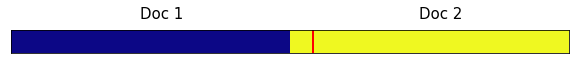

In [9]:
plt.figure(figsize = (10, 10));

# Turn off ticks
plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False);

# Draw a red dividing line between the documents
plt.axvline(x = 12.5, color = 'r', linewidth = 2);

# Label the documents
plt.text(6., -1, 'Doc 1', fontsize = 15, horizontalalignment = 'center');
plt.text(18, -1, 'Doc 2', fontsize = 15, horizontalalignment = 'center');

# Create a 1d array consisting of the current topic assignments,
# then use imshow to color the array according to the topics
image = sum(model.get_document_token_topics(), [])

plt.imshow([image], cmap = 'plasma');

This is a nice, compact visualization of the current topic assignments. We can immediately see that words within a document are nearly all assigned to the same topic, and each document favors a different topic.

Because Gibbs sampling is a stochastic algorithm, the exact topic assignments will fluctuate as we run the algorithm. This is why one of the words in Doc 1 is assigned a different topic than the rest of the words in the document: in any given sampling pass, there is a nonzero (albeit small) probability of making an against-the-grain move like this.

## Trading places

What does the time evolution of the topic assignments look like? In the next two cells we use the compact representation we just created to show how the model evolves over time.

In [10]:
images = []

for i in range(10000):
    model.sweep()
    image = sum(model.get_document_token_topics(), [])
    images.append(image)

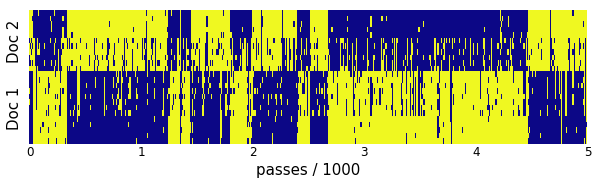

In [11]:
util.plot_topic_trajectory(images, aspect = 10, frac = 0.5)

In this plot, each vertical slice corresponds to the compact representation of a particular assignment of topics. Moving to the right takes you to a new set of topic assignments generated by the Gibbs sampling algorithm.

Something interesting happens in the above plot: **the topics trade places**! This is an important point about LDA: it's invariant to permutation of the topic labels. In other words, it doesn't matter to the model whether **finance** is assigned to topic 0 and **stream** is assigned to topic 1, or vice versa. Given time, the fluctuations in individual topic assignments inherent to the Gibbs sampling algorithm can induce a permutation of the labels. We see this very clearly in the plot above, as the blue and yellow blocks switch documents multiple times over the course of 5000 iterations.

Another way to visualize this label trading is to plot the fraction of occurrences of each word assigned to topic 0, which we do in the next two cells.

In [12]:
# Total corpus-wide count of each word in the vocabulary (for normalizing below)
word_counts = {word: sum(doc.count(word) for doc in example_documents)
               for word in vocab}

# Fraction of each word's appearances assigned to topic 0
wdist_top_0 = {word: [] for word in vocab}

model.sweep(7000)  # churn

for i in range(100):
    model.sweep(10)
    for word in vocab:
        wdist = model.get_word_topic_counts(word)
        wdist_top_0[word].append(wdist[0] / word_counts[word])

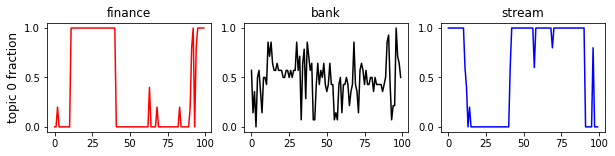

In [13]:
colors = ['red', 'black', 'blue']
plt.figure(figsize = (10, 2));

for i in range(3):
    word = vocab[i]
    plt.subplot(1, 3, i + 1);
    plt.plot(wdist_top_0[word], '-', color = colors[i]);
    plt.yticks([0, 0.5, 1]);
    plt.title(word, fontsize = 12);
    if i == 0:
        plt.ylabel('topic 0 fraction', fontsize = 12);

In the plots above, we can see how the topic assignments fluctuate over time. Looking at the plots for **finance** and **stream**, we can also see clear evidence of the topics trading labels. Since both of these words are primarily associated with a single topic, they tend to favor values of 0 or 1. As the topics trade labels, they switch from 0 to 1 or vice versa. (This label trading is hard to see in the plot for **bank** since this word is shared by the topics.) We can also see that the plots for **finance** and **stream** are very anti-correlated: when one is assigned to topic 0, the other is assigned to topic 1. This is consistent with our intuition that these terms belong to different topics.

## Concluding remarks

We've seen how **LDA** can be used to generate a meaningful and intuitive set of topics given a corpus and vocabulary. We've also seen how **Gibbs sampling** can be used to sample the posterior distribution.

The fluctuating nature of the Gibbs sampling (GS) algorithm is a stark contrast with the other dominant method for posterior inference: expectation-maximization (EM). Whereas GS assigns topics to individual apppearances of words, EM doesn't have this granular characteristic and instead tries to optimize an objective function. The fluctuating nature of GS in comparison to EM has both upsides and downsides.

A major upside of GS over EM is that GS doesn't get stuck in suboptimal local minima. By nature, EM converges to the nearest minimum in the landscape, which may be a poor solution depending on initial conditions. The fluctuations inherent to GS allow it to escape these local minima and reach a better solution. Indeed, if we apply `gensim`'s implementation of LDA (which uses EM for posterior inference) on the corpus and vocabulary we've used in this notebook, we'll get poor solutions a high fraction of the time.

A downside of the fluctuating nature of GS is that it requires averaging multiple samples. This requirement for averaging can be a problem in the face of the label trading that we've observed above because we can end up averaging over permutations of the labels, which will tend to destroy the topical structure we want. In practice, however, this label trading should not be a problem for larger documents and vocabularies. The ease with which our Gibbs sampler was able to permute the topic labels was due to the very small size of the problem we were analyzing; the effective barrier to label permutation should be much larger for more realistic problems. Nonetheless, this is something to keep in mind, particularly when dealing with small corpora and small vocabularies.